# Estimating Proportions

## Goal of Statistics

Statistics seeks to describe characteristics of a broad group (**population**) using only a subset of information (**sample**).  For instance, making statements about all of Chico's graduates would be difficult; we'd first have to find them all and then extract data from each person.  Instead, statistics uses a sample of all graduates to infer characterstics about the population of Chico's graduates.

![](../images/srs.png)

In proper language, a statistician uses a radom sample to calculate sample statistics which provide estimates of population parameters.  Relative to the image above, the population is depicted on the left, the sample is depicted on the right, and the arrows indicate we are to take a simple random sample of **individuals** (or **observations**) from the population.  With these data, we make inferences about the population parameters.  The discipline of statistics studies how to properly use data to make best guesses about the population.  To be useful, we must carefully interpret these best guesses.

At the mathematical level, the population is described by a function, and characteristics of the population are parameters that give structure to these functions.  Data is then theoretically generated from the population's function.  The data, thus carrying information about this function, are used to estimate the population parameters.  As the data side is likely to be more tangible, we'll start there.

## Data

Since this class is both a introduction to R and a statistics course, we'll waste no time introducing R code.  Let's load two of the most common packages, read in a data set (which R calls a **dataframe**), and then make a plot.  For every analysis, big or small, that we perform in this class these three steps should be the very first.f

In [1]:
# library(readr)
library(dplyr)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# HIDDEN
update_geom_defaults("point", list(colour = "blue"))
update_geom_defaults("density", list(colour = "blue"))
update_geom_defaults("path", list(colour = "blue"))
old <- theme_set(theme_bw() + theme(text = element_text(size=18)))

In [3]:
df <- readr::read_csv("~/website/app/public/data/carnivora.csv")
df %>%
    select('SuperFamily', 'Family') %>%
    sample_n(6)

Parsed with column specification:
cols(
  Order = col_character(),
  SuperFamily = col_character(),
  Family = col_character(),
  Genus = col_character(),
  Species = col_character(),
  FW = col_double(),
  SW = col_double(),
  FB = col_double(),
  SB = col_double(),
  LS = col_double(),
  GL = col_double(),
  BW = col_double(),
  WA = col_double(),
  AI = col_double(),
  LY = col_double(),
  AM = col_character(),
  IB = col_character()
)


SuperFamily,Family
Caniformia,Mustelidae
Feliformia,Viverridae
Caniformia,Mustelidae
Feliformia,Viverridae
Feliformia,Felidae
Caniformia,Ailuridae


Warning message:
“Removed 50 rows containing missing values (geom_point).”

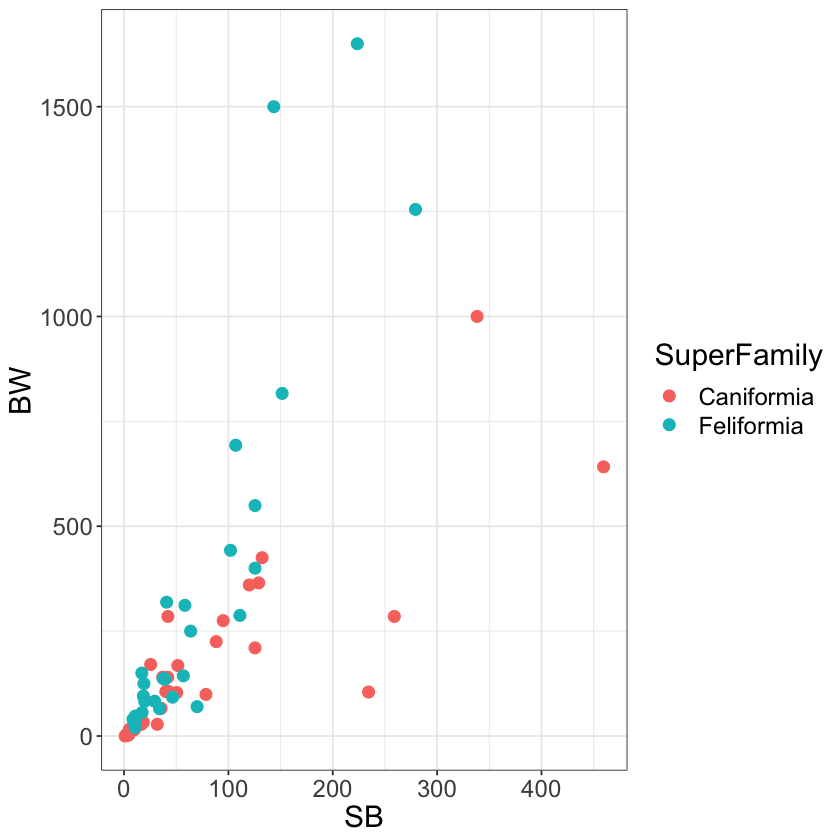

In [4]:
ggplot() +
    geom_point(data=df, aes(SB, BW, color=SuperFamily), size=3)

If these data are truly a random sample (and we're to believe they are), then the proportions of the colors (not the numbers) depict a population parameter.  Here, $p$ might be the population proportion of animals from the order Carnivora that are in the Super Family Caniformia.  As we don't know what value $p$ takes on, we will estimate it with data.

As far as this class is concerned, estimating population parameters from data takes quite a bit of machinery.  The first necessary piece is the (assumed) functional form that represents a proportion.  A common choice for proportions is the Bernoulli distribution.  The Bernoulli distribution will provide us with a function, dependent on some unkown value $p$, from which we collect data and then manipulate to estimate $p$.

## Bernoulli Distribution

The **probability density function** of the [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution)

$$ f(x | p) = p^x (1 - p)^{1-x} $$

for $x \in \{0, 1\}$ and $p \in [0, 1]$.  Notice that $x$ only takes on a finite set of values.  When a random variable can take on only a countable number of values, it is called a **discrete** random variable. 

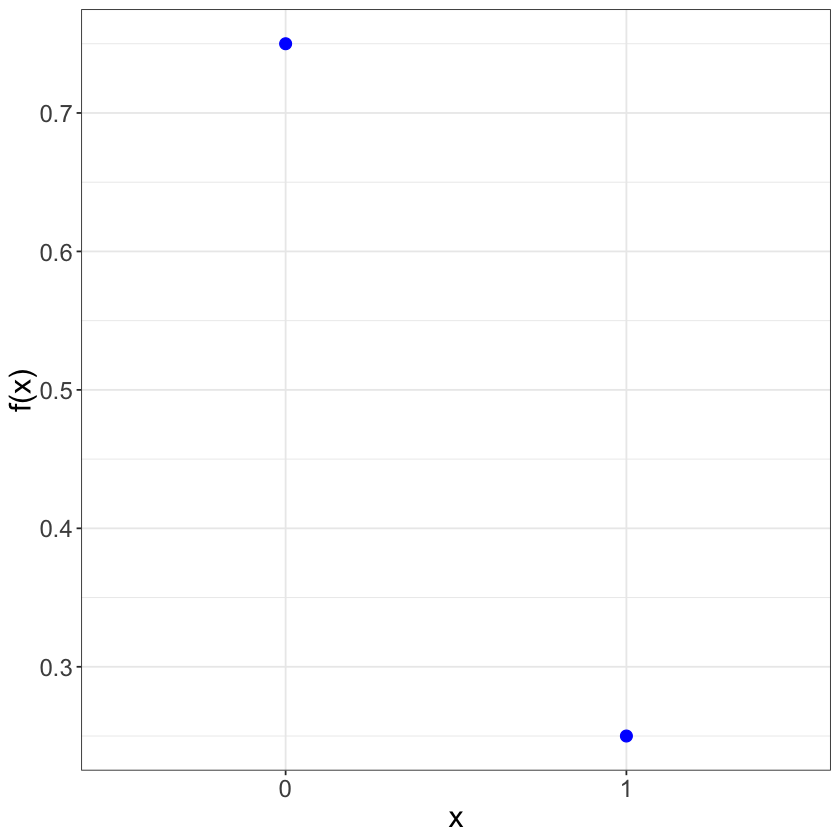

In [5]:
bernoulli <- function(x, p) {
    p^x * (1 - p)^(1 - x)
}
x <- 0:1
p <- 0.25
df <- data.frame(x = x, f = bernoulli(x, p))
ggplot(df, aes(factor(x), f)) + 
    geom_point(size=3) +
    labs(x = 'x', y = 'f(x)')

### Example

Since $x$ only ever takes on two values $0$ or $1$, this matches perfectly with our binary **categorical variable** `SuperFamily`.  The trick is, the **levels** of the variable `SuperFamily` will correspond to the values that the input $x$ of the Bernoulli random variable can take on, namely $0$ and $1$.  How we map from $\\{Canfiromia, Feliformia\\}$ to $\\{0, 1\\}$ is mathematically unimportant, but convention suggests that you are interested in one of the two levels more than the other.

Symbollically, we write $X_n \sim_{iid} \text{Bernoulli}(p)$ for $n = 1, \ldots, N$.  The random variables $X_n$ correspond to the sequence $0$s and $1$s that tell us which observations belong to the Super Family Caniformia.  The population **parameter** $p$ is unwknown, but can be estimated with the data $X_n$.  Notice that for Bernoulli data, the sample (because it's applied to data) mean returns a **proportion** since at most the sum of $N$ $1$s is $N$.

In [6]:
library(dplyr)
carnivora <- read.csv("~/website/app/public/data/carnivora.csv") %>%
    mutate(Caniformia = as.numeric(SuperFamily == 'Caniformia')) # interested in Canfiformia
(phat <- round(mean(carnivora$Caniformia), 2))

[1] 0.51

Much of this class involves interpretting **statistics** such as the one above.  We'd say based on our data, approximately $51$% of the animals in the Order Carnivora are in the Super Family Caniformia.

One the one hand, we need to recognize that this proportion is an estimate of the (population) parameter $p$ in the context of our study -- sampled animals, hopefully randomly, from the Super Families Caniformia and Feliformia within a specific geographic region.  On the other hand, since this is a random sample, there's some uncertainty to this estimate.

The remainder of this class will focus on two subtle points: how do we 

1. estimate parameters, and 
2. quantify the uncertainty in our estimates?

The answers (as far as this class is concerned) are the

1. likelihood, and
2. bootstrap

respectively.

## Likelihood

The likelihood function enables estimation of population parameters given a sample of data.  The likelihood function is not the only means for estimating population parameters, but it is the only method we will cover in this class.

### Definition

Given a random sample of **independent and identically distributed** data, $X_n \sim_{iid} F(\theta)$ for $n = 1, \ldots, N$, the likelihood function is 

$$ L(\theta | \mathbf{X}) = \prod_{n=1}^N f(x_n | \theta),$$

where $\mathbf{X}$ is just notation for our random sample of data, $\theta \in \mathbb{R}^d$ denotes the parameter(s) to be estimated, and $f(x\vert \theta)$ is the probability density function associated with the distribution $F$.  Given the likelihood function $L$, estimates are produced by finding the value of $\theta$ that maximizes the likelihood function.

### Maximum Likelihood Estimators

Assume we have data $X_n \sim_{iid} F(\theta)$.  The **maximum likelihood estimator** (MLE) of $\theta$ is

$$ \hat{\theta} = argmax_{\theta} L(\theta | \mathbf{X}).$$

### Finding MLEs

The definitions above are intimidating upon first site.  However, with a breif recap of some algebraic manipulations and a few tips on getting started, finding MLEs can often be reduced down to a rehearsal of maximization/minimization probelems of calculus 1.  Let's start with some quick exercises to refresh our minds of the algebra we'll need to find MLEs.

1. How can we rewrite (simplify?) the following equations?
    * $\log{(a \cdot b)}$?
    * $\log{(x_1 \cdot x_2)}$?
    * $\log{(x_1 \cdot x_2 \cdot \ldots \cdot x_n)}$?
    * $\log{(\prod_{i=1}^n x_i)}$?
    * $\log{(\prod_{i=1}^n f(x_i))}$?

2. How can we rewrite (simplify?) the following equations?
    * $\frac{d}{d \theta} \{a \cdot \theta + b \cdot \theta\}$?
    * $\frac{d}{d \theta} \{x_1 \cdot \theta + x_2 \cdot \theta\}$?
    * $\frac{d}{d \theta} \{x_1 \cdot \theta + \ldots + x_n \cdot \theta\}$?
    * $\frac{d}{d \theta} \{\sum_{i=1}^n x_i \cdot \theta \}$?

3. Evaluate the following expression,

$$ \frac{d}{d \theta} (x\cdot \log{(1-\theta))}.$$

Next, a hint for getting started on maximizing a function with nasty exponents.  It's immensely helpful (to both humans and computers) to work with the natural log of the likelihood function, cleverly named the log-likelihood function
 

$$ \ell (\theta|\mathbf{x}) = \log{L(\theta|\mathbf{x}) = \sum_{n=1}^N \log{f(x_n|\theta)}}. $$


### Example

Consider $X_n \sim_{iid} \text{Bernoulli}(p)$ for $n = 1, \ldots, N$.  Find the MLE of $p$ and call it $\hat{p}$.